In [29]:
import argparse
import cv2, os, glob
from collections import OrderedDict
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from maskrcnn_benchmark.config import cfg
from copy import deepcopy

IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

# red, green, blue, yellow, pink, sea, wite, green
color = [(255,0,0), (0,255,0),(0,0,255),\
         (255,255,0),(255,0,255),(0,255,255),(255,255,255),\
         (100,255,0),(100,0,255),(255,100,0),(0,100,255),(255,0,100),(0,255,100),(0,0,0)]
def get_color(i):
    m = len(color)
    return color[i] if i < m else color[i%m]

cfg.merge_from_file('e2e_mask_rcnn_R_50_FPN_1x.yaml')

In [3]:
from maskrcnn_benchmark.data.utils.auto_lane_codec_utils import nms_with_pos
rx, ry = 1280/512., 720/256.
stride = 16.

In [3]:
outputs_dict = torch.load("exp/oct23/inference/aicom_lane_test/oct23_debug01_m_0.pth", 
                          map_location=torch.device("cpu")) 
det_pred = torch.load("exp/oct23/inference/aicom_lane_test/det_oct23_debug01_m_0.pth", 
                          map_location=torch.device("cpu")) 
pred = outputs_dict["predictions"]
test_imgs = outputs_dict["test_images"]
def get_imgs(idx):
    #return cv2.imread(paths[idx])
    return cv2.imread(test_imgs[idx])

In [4]:
###################### big
outputs_dict = torch.load("exp/oct23/inference/aicom_lane_test/oct23_res04_r0.pth", 
                          map_location=torch.device("cpu")) 
pred = outputs_dict["predictions"]
test_imgs = outputs_dict["test_images"]
def get_imgs(idx):
    #return cv2.imread(paths[idx])
    return cv2.imread(test_imgs[idx])

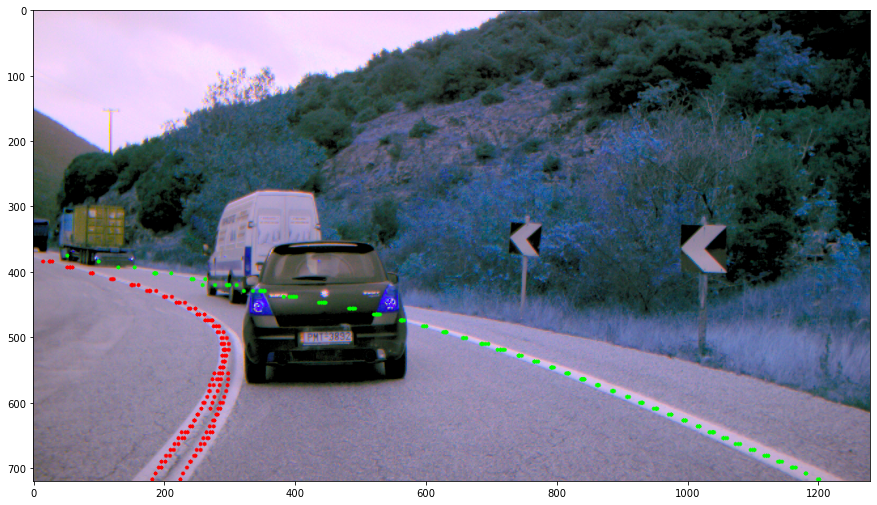

In [35]:
# red, green, blue, yellow, pink, sea, wite, green
idx = 8510  # 2, 7, 8, 9, 10, 11, 13?, 16snow, 18 7906
im = get_imgs(idx)
for i, group in enumerate(pred[idx]):
    for l in group:
        for pt in l:
            x,y = int(pt[0]*rx), int(pt[1]*ry)
            cv2.circle(im, (x,y), 3, get_color(i), -1)
        
plt.figure(figsize=(15, 15))
plt.imshow(im)
plt.show() 

In [22]:
# red, green, blue, yellow, pink, sea, wite, green
for idx in tqdm(pred.keys()):
    if random.random() < 0.01:
        final_lines = post_proc_util.post_proc(pred[idx],
                        rx=1280/512., ry=720/256., stride=16.)
        img_write(test_imgs, idx, final_lines)


100%|██████████| 13556/13556 [01:30<00:00, 149.33it/s]


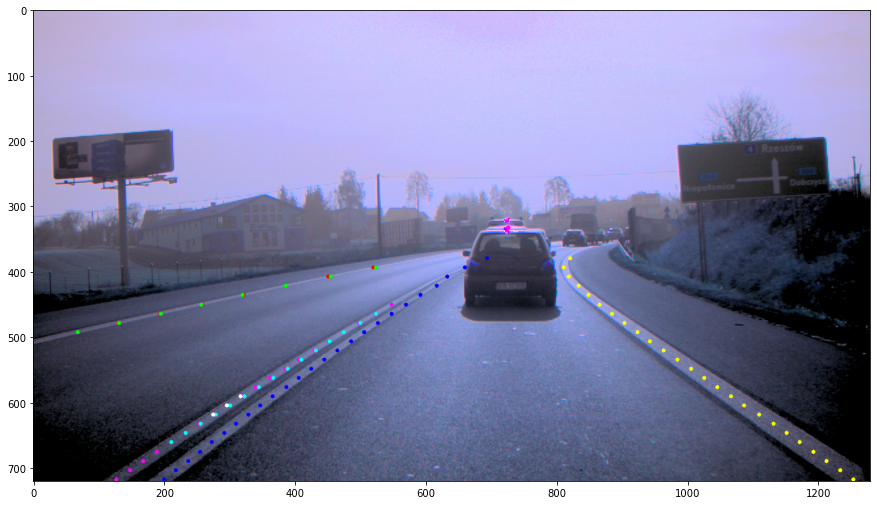

In [121]:
from scipy import interpolate
import numpy as np

default_sample = np.arange(0., 719., step=5.)
lines_sample = list()
lines_info = list()
for i, (xl,yl) in enumerate(zip(in_x,in_y)):
    if len(yl) <= 1:
        continue # ignore this line as only 1 point
    
    ### merge_same_y(yl,xl)
    
    y_max, y_min = max(yl), min(yl)
    yl, xl = np.array(yl), np.array(xl)
    ind = np.argsort(yl) # small->big
    yl, xl = yl[ind], xl[ind]

    ###
    pt_lower = np.array([ xl[-1], yl[-1] ])
    pt_upper = np.array([ xl[0], yl[0] ])
    
    ###
    if len(yl) <= 3:
        k = len(yl) - 1
        print("pts len: {}, thus choose k: {}".format(len(yl), k))
        tck = interpolate.splrep(x=yl, y=xl, s=0, k=k)
    else:
        tck = interpolate.splrep(x=yl, y=xl, s=0)
    
    ### create sampled points
    y_sample = default_sample[default_sample>=y_min]
    y_sample = y_sample[y_sample<=y_max]
    x_sample = interpolate.splev(x=y_sample, tck=tck, der=0)
    lines_sample.append([x_sample,y_sample])
    # print(i, x_sample,y_sample)
    lines_info.append({
        'tck': tck,
        'y_max': y_max,
        'y_min': y_min,
        'pt_lower':pt_lower, # bound in lower image
        'pt_upper':pt_upper, # bound in upper image
    })

im = get_imgs(idx)
for i,(xl, yl) in enumerate(lines_sample):
    for x, y in zip(xl, yl):
        x = int(x*rx)
        y = int(y*ry)
        cv2.circle(im, (x, y), 3, get_color(i), -1)

plt.figure(figsize=(15, 15))
plt.imshow(im)
plt.show() 

In [126]:
# l1 and l2 should sorted along y (small->big)
# lines_info{tck, y_max, y_min}
# import math

def compute_dist(l1, l2):
    tck1 = l1['tck']
    tck2 = l2['tck']
    upper_bound = max(l1['y_min'], l2['y_min'])
    lower_bound = min(l1['y_max'], l2['y_max'])
    
    if upper_bound > lower_bound:
        # seprated line
        print("line seprated in y")
        
        if l1['y_max'] < l2['y_min']:
            p1, p2 = l1['pt_lower'], l2['pt_upper']
            return np.sqrt(np.sum( (p1 - p2)**2 ))
            
        elif l2['y_max'] < l1['y_min']:
            p1,p2 = l2['pt_lower'], l1['pt_upper']
            return np.sqrt(np.sum( (p1 - p2)**2 ))
        
        else:
            print("error")
                
    elif upper_bound == lower_bound:
        # connected line
        print("line connected in y")
        
        if l1['y_max'] == l2['y_min']:
            p1, p2 = l1['pt_lower'], l2['pt_upper']
            return np.sqrt(np.sum( (p1 - p2)**2 ))
            
        elif l2['y_max'] == l1['y_min']:
            p1,p2 = l2['pt_lower'], l1['pt_upper']
            return np.sqrt(np.sum( (p1 - p2)**2 ))
        
        else:
            print("error")
    else: 
        # overlaped line
        print("overlaped line")
        ys_sample = np.arange(upper_bound, lower_bound, step=2.)
        xs_sample1 = interpolate.splev(x=ys_sample, tck=tck1, der=0)
        xs_sample2 = interpolate.splev(x=ys_sample, tck=tck2, der=0)
        dists = np.abs(xs_sample1 - xs_sample2)
        dist_sum = np.sum(dists) / len(ys_sample)
        return dist_sum

In [127]:
compute_dist(lines_info[0], lines_info[6])

line seprated in y


124.58363523331239

In [110]:
#from copy import deepcopy
# lane_sorted = sorted(lane_set) # along prob
thresh = 15
lines = lines_info
result = list()
selected = [False] * len(lines) # [False, False, False, False]
for n in range(len(lines)):
    if selected[n]:
        continue
    result.append(list()) # create a new line (contain ids)
    result[-1].append(n)
    selected[n] = True
    for t in range(n + 1, len(lines)):
        if selected[t]:
            continue
        dis = compute_dist(lines[n], lines[t])
        if dis <= thresh: # find close line(t-th) of n-th line
            selected[t] = True 
            result[-1].append(t) # merge t-th lane


overlaped line
overlaped line
overlaped line
overlaped line
overlaped line
seprated line
overlaped line
overlaped line
overlaped line
overlaped line
overlaped line
overlaped line
overlaped line
overlaped line
overlaped line


In [111]:
result

[[0, 1], [2], [3], [4, 5, 6]]

In [113]:
#for i, (xl,yl) in enumerate(zip(in_x,in_y)):
regroup_lines = list()
for i, lids in enumerate(result):
    temp = list()
    for lid in lids:
        xl, yl = in_x[lid], in_y[lid]
        temp.extend([[x,y] for x,y in zip(xl,yl)])
    regroup_lines.append(temp)

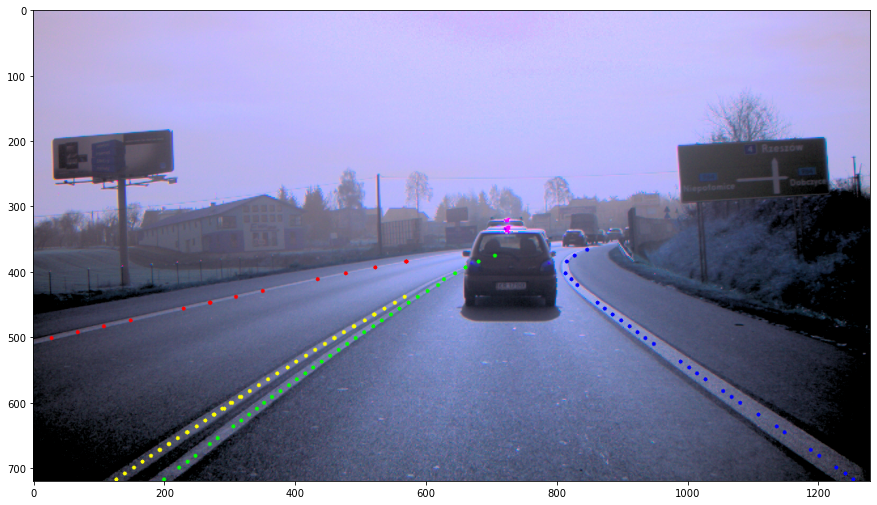

In [114]:
### show points in image
im = get_imgs(idx)
for i, l in enumerate(regroup_lines):
    for x, y in l:
        x = int(x*rx)
        y = int(y*ry)
        cv2.circle(im, (x, y), 3, get_color(i), -1)

plt.figure(figsize=(15, 15))
plt.imshow(im)
plt.show() 

In [27]:
def eliminate_out(sorted_x, sorted_y, confidence = None, image = None):
    out_x = []
    out_y = []

    for lane_x, lane_y in zip(sorted_x, sorted_y):

        lane_x_along_y = np.array(deepcopy(lane_x))
        lane_y_along_y = np.array(deepcopy(lane_y))

        ind = np.argsort(lane_x_along_y, axis=0)
        lane_x_along_x = np.take_along_axis(lane_x_along_y, ind, axis=0)
        lane_y_along_x = np.take_along_axis(lane_y_along_y, ind, axis=0)
        
        if lane_y_along_x[0] > lane_y_along_x[-1]: #if y of left-end point is higher than right-end
            starting_points = [(lane_x_along_y[0], lane_y_along_y[0]), 
                               (lane_x_along_y[1], lane_y_along_y[1]), 
                               (lane_x_along_y[2], lane_y_along_y[2]),
                                (lane_x_along_x[0], lane_y_along_x[0]), 
                               (lane_x_along_x[1], lane_y_along_x[1]), 
                               (lane_x_along_x[2], lane_y_along_x[2])] # some low y, some left/right x
        else:
            starting_points = [(lane_x_along_y[0], lane_y_along_y[0]), 
                               (lane_x_along_y[1], lane_y_along_y[1]), 
                               (lane_x_along_y[2], lane_y_along_y[2]),
                                (lane_x_along_x[-1], lane_y_along_x[-1]), 
                               (lane_x_along_x[-2], lane_y_along_x[-2]), 
                               (lane_x_along_x[-3], lane_y_along_x[-3])] # some low y, some left/right x            
    
        temp_x = []
        temp_y = []
        for start_point in starting_points:
            temp_lane_x, temp_lane_y = generate_cluster(start_point, lane_x, lane_y, image)
            temp_x.append(temp_lane_x)
            temp_y.append(temp_lane_y)
        
        max_lenght_x = None
        max_lenght_y = None
        max_lenght = 0
        for i, j in zip(temp_x, temp_y):
            if len(i) > max_lenght:
                max_lenght = len(i)
                max_lenght_x = i
                max_lenght_y = j
        out_x.append(max_lenght_x)
        out_y.append(max_lenght_y)

    return out_x, out_y


# image is useless
def generate_cluster(start_point, lane_x, lane_y, image = None):
    cluster_x = [start_point[0]]
    cluster_y = [start_point[1]]

    point = start_point
    while True:
        points = util.get_closest_upper_point(lane_x, lane_y, point, 3)
         
        max_num = -1
        max_point = None

        if len(points) == 0:
            break
        if len(points) < 3:
            for i in points: 
                cluster_x.append(i[0])
                cluster_y.append(i[1])                
            break
        for i in points: 
            num, shortest = util.get_num_along_point(lane_x, lane_y, point, i, image)
            if max_num < num:
                max_num = num
                max_point = i

        total_remain = len(np.array(lane_y)[np.array(lane_y) < point[1]])
        cluster_x.append(max_point[0])
        cluster_y.append(max_point[1])
        point = max_point
        
        if len(points) == 1 or max_num < total_remain/5:
            break

    return cluster_x, cluster_y